In [1]:
!pip install -q datasets torchcfm

In [2]:
from datasets import load_dataset

ds = load_dataset("bahjat-kawar/tedbench", split="val")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import torch
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_encoder = SentenceTransformer("all-mpnet-base-v2").to(device)

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
from torch.utils.data import Dataset, DataLoader

class TextGuidedImageGenerationDataset(Dataset):
    def __init__(self, dataset, transform, text_encoder, device):
        self.dataset = dataset
        self.transform = transform
        self.text_encoder = text_encoder
        self.device = device
        self.original_images = dataset["original_image"]
        self.captions = dataset["caption"]
        self.edited_images = dataset["edited_image"]
        self.embed_captions = text_encoder.encode(
            self.captions, convert_to_tensor=True, device=self.device
        )

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        # Đảm bảo ảnh là RGB (3 kênh)
        original_image = self.original_images[idx].convert("RGB")
        original_image = self.transform(original_image)

        edited_image = self.edited_images[idx].convert("RGB")
        edited_image = self.transform(edited_image)

        caption = self.captions[idx]
        caption_embedding = self.embed_captions[idx]

        return {
            "original_image": original_image,
            "edited_image": edited_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

# Tạo dataset & dataloader
train_ds = TextGuidedImageGenerationDataset(
    ds, transform, text_encoder, device
)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)


In [6]:
sample = next(iter(train_ds))

## **Model**

In [7]:
import math
import torch
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels, num_channels*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels*2, num_channels*4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.embedding_layer = nn.Linear(embedding_dim, num_channels*4)
        self.fc = nn.Linear(num_channels*12, num_channels*4)

    def forward(self, t, x, text_embeddings=None, original_image=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if (text_embeddings is not None) and (original_image is not None):
            text_embedded = self.embedding_layer(text_embeddings)
            image_embedded = self.image_encoder(original_image).squeeze(2).squeeze(2)  # B x C
            emb = torch.cat([emb, text_embedded, image_embedded], dim=1)
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)


In [8]:
model = UNetModelWithTextEmbedding(
    dim=(3, 64, 64), num_channels=32, num_res_blocks=1, embedding_dim=768
).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [9]:
from tqdm import tqdm

n_epochs = 5000
for epoch in tqdm(range(n_epochs)):
    losses = []
    model.train()

    for batch in train_loader:
        optimizer.zero_grad()

        original_image = batch["original_image"].to(device)
        edited_image = batch["edited_image"].to(device)
        caption_embedding = batch["caption_embedding"].to(device)

        x1 = edited_image
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0
        t = t.squeeze()  # shape: (batch_size,)

        vt = model(t, xt, text_embeddings=caption_embedding, original_image=original_image)

        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}")


 10%|█         | 500/5000 [21:14<3:11:16,  2.55s/it]

Epoch [500/5000], Loss: 0.0634


 20%|██        | 1000/5000 [42:23<2:49:19,  2.54s/it]

Epoch [1000/5000], Loss: 0.0545


 30%|███       | 1500/5000 [1:03:37<2:28:43,  2.55s/it]

Epoch [1500/5000], Loss: 0.0528


 40%|████      | 2000/5000 [1:24:51<2:07:25,  2.55s/it]

Epoch [2000/5000], Loss: 0.0518


 50%|█████     | 2500/5000 [1:46:02<1:45:08,  2.52s/it]

Epoch [2500/5000], Loss: 0.0514


 60%|██████    | 3000/5000 [2:07:07<1:24:13,  2.53s/it]

Epoch [3000/5000], Loss: 0.0290


 70%|███████   | 3500/5000 [2:28:10<1:03:05,  2.52s/it]

Epoch [3500/5000], Loss: 0.0445


 80%|████████  | 4000/5000 [2:49:13<42:05,  2.53s/it]

Epoch [4000/5000], Loss: 0.0595


 90%|█████████ | 4500/5000 [3:10:16<21:05,  2.53s/it]

Epoch [4500/5000], Loss: 0.0383


100%|██████████| 5000/5000 [3:31:19<00:00,  2.54s/it]

Epoch [5000/5000], Loss: 0.0420


In [11]:
model.eval()

def euler_method(model, text_embedding, t_steps, dt, noise, original_image):
    y = noise
    y_values = [y]
    with torch.no_grad():
        batch_size = y.shape[0]
        for t in t_steps[1:]:
            t = t.expand(batch_size)  # Đồng bộ batch size
            dy = model(t.to(device), y, text_embeddings=text_embedding, original_image=original_image)
            y = y + dy * dt
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
noise = torch.randn_like(original_image, device=device)
text_embedding = caption_embedding

# Time parameters
t_steps = torch.linspace(0, 1, 100, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embedding, t_steps, dt, noise, original_image)


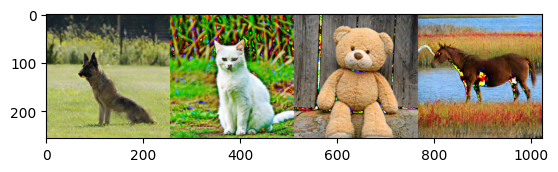

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    results[-1].clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.savefig("text_guided.png", dpi=300)
plt.show()